In [289]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import itertools
import random
from tqdm.notebook import tqdm_notebook
from tqdm.contrib.itertools import product

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import colors
import matplotlib.patches as patches
import seaborn as sns

plt.rcParams['text.usetex'] = True

import warnings
warnings.filterwarnings('ignore')

In [3]:
class GassuianMixtureDistribuiton:

    def __init__(self, pos_prob, pos_mu, pos_std, neg_mu, neg_std):
        self.pos_prob = pos_prob
        self.pos_mu = pos_mu
        self.pos_std = pos_std
        self.neg_mu = neg_mu
        self.neg_std = neg_std

    def sample(self, n):
        y = np.random.binomial(1, self.pos_prob, n)
        x = (y == 1) * np.random.normal(self.pos_mu, self.pos_std, n) + (y == 0) * np.random.normal(self.neg_mu, self.neg_std, n)
        return x, y

    def sample_conditioned_on_y(self, n, y):
        x = (y == 1) * np.random.normal(self.pos_mu, self.pos_std, n) + (y == 0) * np.random.normal(self.neg_mu, self.neg_std, n)
        return x

In [4]:
class LinearClassifier:

    def __init__(self, enc_z, b=0.5):
        self.enc_z = enc_z
        self.cls = LogisticRegression(penalty=None)
        self.b = b

    def prepare_data(self, Z, X):
        Z_onehot = self.enc_z.transform(Z.reshape(-1, 1)).toarray()
        return np.concatenate((Z_onehot, X.reshape(-1, 1)), axis=1)

    def fit(self, Z, X, Y):
        train_input = self.prepare_data(Z, X)
        self.cls.fit(train_input, Y)

    def __call__(self, Z, X):
        if len(Z) == 0:
            return np.array([])
        input = self.prepare_data(Z, X)
        probs = self.cls.predict_proba(input)
        return (probs[:, 1] > self.b).astype(int)

    def set_b(self, b):
        self.b = b



def get_classificaiton_statistics(Z, X, Y, cls):
    Yhat = cls(Z, X)
    dfs = []
    for z, y, yhat in itertools.product(Z_vals, [0, 1], [0, 1]):
        dfs.append(pd.DataFrame({
            "z": [z],
            "y": y,
            "yhat": yhat,
            "count": ((Z == z) & (Y == y) & (Yhat == yhat)).sum()
        }))
    stats = pd.concat(dfs)
    return stats

In [5]:
eps = 0.001

def precision(stats):
    if stats["count"].sum() == 0:
        return -1
    enum = stats[(stats.yhat == 1) & (stats.y == 1)]["count"].sum()
    denom = stats[stats.yhat == 1]["count"].sum() + eps
    return enum / denom


def accuracy(stats):
    if stats["count"].sum() == 0:
        return -1
    return stats[stats.yhat == stats.y]["count"].sum() / stats["count"].sum()


def will_apply(z, stats, c_u):
    return float(precision(stats[stats.z == z]) > c_u) 


def get_applicaiton_decision_for_Z(Z, stats, c_u):
    A = np.zeros(len(Z))
    for z in Z_vals:
        A[Z == Z] = will_apply(z, stats, c_u)
    return A


def get_induced_distribution(Z, X, Y, stats, c_u):
    Z_f_list, X_f_list, Y_f_list = [], [], []
    for z in np.unique(Z):
        if will_apply(z, stats, c_u):
            idx = np.where(Z == z)
            Z_f_list.append(Z[idx])
            X_f_list.append(X[idx])
            Y_f_list.append(Y[idx])
    if len(Z_f_list) == 0:
        Z_f_list, X_f_list, Y_f_list = [np.array([])], [np.array([])], [np.array([])]
    return np.concatenate(Z_f_list), np.concatenate(X_f_list), np.concatenate(Y_f_list)


def system_utility(A, Yhat, Y):
    return (A * Yhat * (Y - c_s)).mean()

def system_utility_on_participating_users(A, Yhat, Y):
    return (Yhat * (Y - c_s))[A == 1].mean()

In [6]:
def changing_threshold_exp(cls, Z, X, Y, c_u, n=100):

    dfs = []
    b_values = np.linspace(0, 0.99, n)
    for b in tqdm_notebook(b_values):
        cls.set_b(b)
        Yhat = cls(Z, X)
        stats = get_classificaiton_statistics(Z, X, Y, cls)
        A = get_applicaiton_decision_for_Z(Z, stats, c_u)
        applications = [will_apply(z, stats, c_u) for z in Z_vals]
        Z_f, X_f, Y_f = get_induced_distribution(Z, X, Y, stats, c_u)
        Yhat_f = cls(Z_f, X_f)
        induced_stats = get_classificaiton_statistics(Z_f, X_f, Y_f, cls)

        data = {
                "acc": [accuracy(stats)],
                "prec": precision(stats),
                "induced_acc": accuracy(induced_stats),
                "induced_prec": precision(induced_stats),
                "mean_y_f": Y_f.mean(),
                "induced_util_s": system_utility(A, Yhat, Y),
                "induced_util_s_on_participating_users": system_utility_on_participating_users(A, Yhat, Y),
                "mean_apply": A.mean(),
                "mean_pass_screening": (A * Yhat).mean(),
                "b": b
            }
        for i in Z_vals:
            data[f"z{i}_apply"] = will_apply(i, stats, c_u)
            data[f"z{i}_prec"] = precision(stats[stats.z == i])
            data[f"z{i}_acc"] = accuracy(stats[stats.z == i])
        dfs.append(
            pd.DataFrame(data))
    results = pd.concat(dfs)
    return results

In [450]:
dists = []
pos_probs = [0.5, 0.5, 0.15, 0.85]

pos_prob = pos_probs[0]
pos_mu = 0.5
pos_std = 0.5
neg_mu = -0.5
neg_std = 0.5
z0_dist = GassuianMixtureDistribuiton(pos_prob, pos_mu, pos_std, neg_mu, neg_std)
dists.append(z0_dist)

pos_prob = pos_probs[1]
pos_mu = 0.5
pos_std = 0.5
neg_mu = -0.5
neg_std = 0.5
z1_dist = GassuianMixtureDistribuiton(pos_prob, pos_mu, pos_std, neg_mu, neg_std)
dists.append(z1_dist)

pos_prob = pos_probs[2]
pos_mu = 0.5
pos_std = 0.5
neg_mu = -0.5
neg_std = 0.5
z2_dist = GassuianMixtureDistribuiton(pos_prob, pos_mu, pos_std, neg_mu, neg_std)
dists.append(z2_dist)

pos_prob = pos_probs[3]
pos_mu = 0.5
pos_std = 0.5
neg_mu = -0.5
neg_std = 0.5
z3_dist = GassuianMixtureDistribuiton(pos_prob, pos_mu, pos_std, neg_mu, neg_std)
dists.append(z3_dist)

In [451]:
cs_u = [0.8, 0.8, 0.9]
c_s = 0.8 

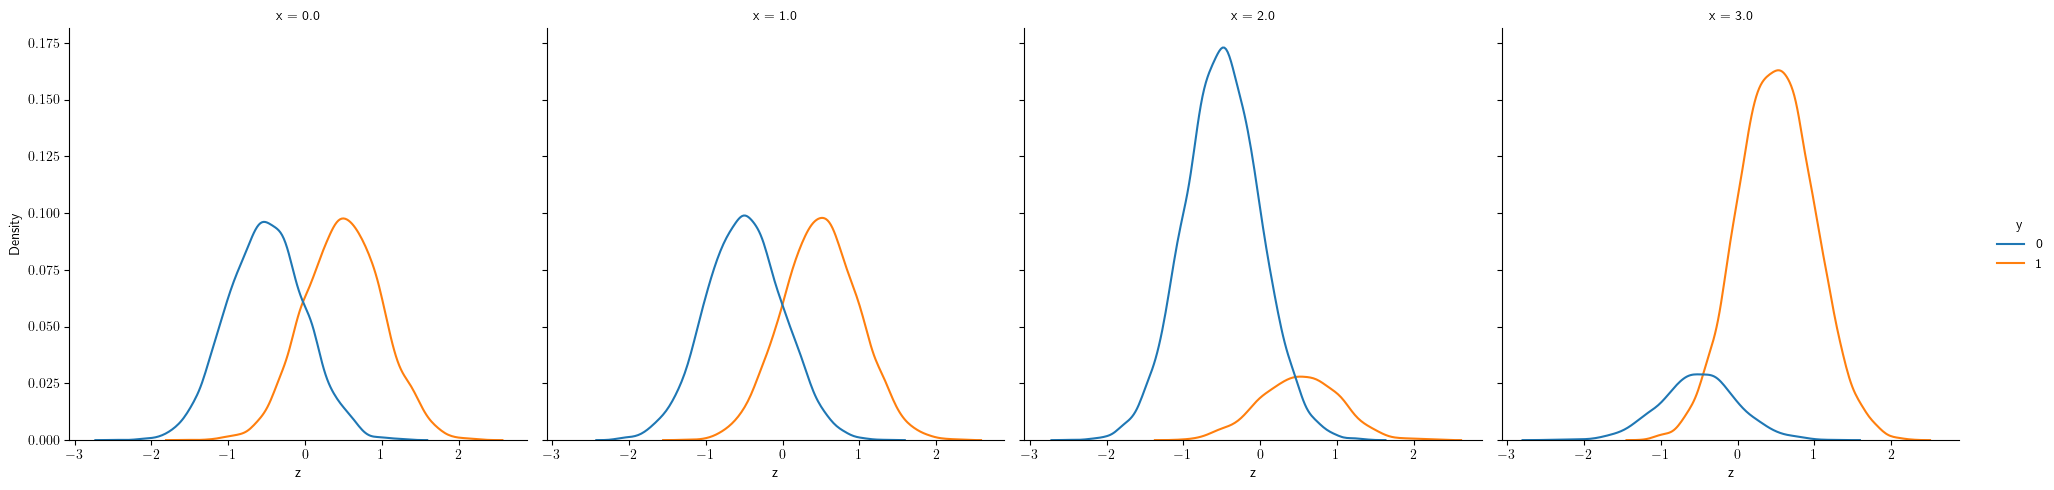

In [452]:
n_samples = 10000

z0_x, z0_y = z0_dist.sample(n_samples)
z1_x, z1_y = z1_dist.sample(n_samples)
z2_x, z2_y = z2_dist.sample(n_samples)
z3_x, z3_y = z3_dist.sample(n_samples)

Z_vals = [0, 1, 2, 3]
Z = np.concatenate([np.ones(n_samples) * val for val in Z_vals])
X = np.concatenate([z0_x, z1_x, z2_x, z3_x])
Y = np.concatenate([z0_y, z1_y, z2_y, z3_y])
Z_values = np.unique(Z)

data = pd.DataFrame({"z": Z, "x": X, "y": Y})

sns.displot(data, x="x", hue="y", col="z", kind="kde")

plt.show()

In [453]:
def train(data, classes, c_u, n=100):
    Z = data[(data["z"] == classes[0]) | (data["z"] == classes[1])]["z"].values
    X = data[(data["z"] == classes[0]) | (data["z"] == classes[1])]["x"].values
    Y = data[(data["z"] == classes[0]) | (data["z"] == classes[1])]["y"].values
    Z_vals = np.unique(Z)
    enc_z = OneHotEncoder(handle_unknown='ignore')
    enc_z.fit(Z.reshape(-1, 1))

    naive_cls = LinearClassifier(enc_z)
    naive_cls.fit(Z, X, Y)

    Yhat = naive_cls(Z, X)
    stats = get_classificaiton_statistics(Z, X, Y, naive_cls)
    apps = [will_apply(z, stats, c_u) for z in Z_vals]
    Z_f, X_f, Y_f = get_induced_distribution(Z, X, Y, stats, c_u)
    Yhat_f = naive_cls(Z_f, X_f)
    induced_stats = get_classificaiton_statistics(Z_f, X_f, Y_f, naive_cls)

    naive_cls_acc = accuracy(stats)
    naive_cls_induced_acc = accuracy(induced_stats)
    accs = [naive_cls_acc, naive_cls_induced_acc]
    print(f"Naive classifier results:\n\tApplicaitons: a_0={apps[0]}, a_1={apps[1]}\n\tAcc: {naive_cls_acc}\n\tInduced Acc: {naive_cls_induced_acc}")

    coef = naive_cls.cls.coef_[0].copy()
    intrcpt = naive_cls.cls.intercept_.copy()
    print(coef, intrcpt)
    coef[:-1] += intrcpt
    coef /= coef[-1]
    
    naive_res = changing_threshold_exp(naive_cls, Z, X, Y, c_u, n)
    return naive_res, accs, apps, coef

n = 100
res1, accs1, apps1, coef1 = train(data, [0,1], cs_u[0], n)
res2, accs2, apps2, coef2 = train(data, [0,2], cs_u[1], n)
res3, accs3, apps3, coef3 = train(data, [0,3], cs_u[2], n)

Naive classifier results:
	Applicaitons: a_0=1.0, a_1=1.0
	Acc: 0.83775
	Induced Acc: 0.83775
[ 0.03574573 -0.02958748  3.96463939] [0.00615826]


  0%|          | 0/100 [00:00<?, ?it/s]

Naive classifier results:
	Applicaitons: a_0=1.0, a_1=0.0
	Acc: 0.87205
	Induced Acc: 0.8367
[ 0.60174102 -1.16158272  3.96548242] [-0.5598417]


  0%|          | 0/100 [00:00<?, ?it/s]

Naive classifier results:
	Applicaitons: a_0=0.0, a_1=1.0
	Acc: 0.8729
	Induced Acc: 0.9091
[-0.55919869  1.16083524  4.02459732] [0.60163655]


  0%|          | 0/100 [00:00<?, ?it/s]

In [486]:
path = './'
SAVE = False

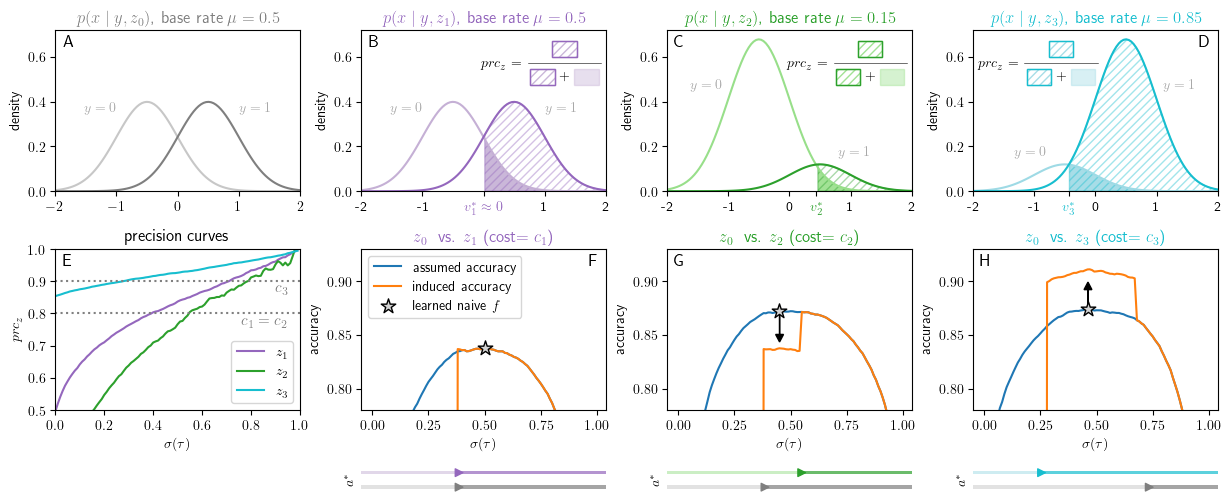

In [487]:
fig = plt.figure() #(constrained_layout=True)
fig.set_size_inches(15,6)
spec = fig.add_gridspec(ncols=4, nrows=3, height_ratios=[1,1,0.15], hspace=0.5, wspace=0.25)

axs = [[]]*12

x_ = np.linspace(-2,2,n)

tab20 = plt.get_cmap('tab20')
clrs = [[tab20(15),tab20(14)], [tab20(9),tab20(8)], [tab20(5),tab20(4)], [tab20(19),tab20(18)]]
# clrs = [['grey','black'],['lightblue','navy'],['wheat','darkorange'],['palegreen','darkgreen']]

def Gaussians(dist):
    y0 = (1-dist.pos_prob) * np.exp(-0.5 * ((x_ - dist.neg_mu) / dist.neg_std)**2) / (dist.neg_std * np.sqrt(2 * np.pi))
    y1 = dist.pos_prob * np.exp(-0.5 * ((x_ - dist.pos_mu) / dist.pos_std)**2) / (dist.pos_std * np.sqrt(2 * np.pi))
    return np.asarray([y0,y1]).T

def fill_partial_ge(ax,x0,idx):
    line = ax.get_lines()[idx]
    x, y = line.get_data()
    mask = x >= x0
    x, y = x[mask], y[mask]
    return x,y

def sig(z):
    return 1./(1+np.exp(-z))

# plot distributions:
for i,dist in enumerate(dists):
    axs[i] = fig.add_subplot(spec[0,i])
    y_ = Gaussians(dist)
    axs[i].plot(x_,y_[:,0],c=clrs[i][0])
    axs[i].plot(x_,y_[:,1],c=clrs[i][1])
    axs[i].set_title(r'$p(x\mid y,z_{})$, base rate $\mu={}$'.format(i,pos_probs[i]),color=clrs[i][1])
    axs[i].set_ylabel('density')
    axs[i].set_ylim(0,0.72)
    axs[i].set_xlim(-2,2)

coefs = [coef1, coef2, coef3]
vs = [-coefs[i][1] for i in range(3)]

for i in range(3):
    x_, y_ = fill_partial_ge(axs[i+1],vs[i],0)
    axs[i+1].fill_between(x_, y1=y_, alpha=0.9, facecolor=clrs[i+1][0])
    x_, y_ = fill_partial_ge(axs[i+1],vs[i],1)
    axs[i+1].fill_between(x_, y1=y_, alpha=0.4, facecolor="none", hatch="////", edgecolor=clrs[i+1][1])
    


axs[1].set_xticks([-2,-1,vs[0],1,2])
axs[1].get_xticklabels()[2].set_color(clrs[1][1])
axs[1].set_xticklabels([-2,-1,r'$v^*_1 \approx 0$',1,2])

axs[2].set_xticks([-2,-1,0,vs[1],1,2])
axs[2].get_xticklabels()[3].set_color(clrs[2][1])
axs[2].set_xticklabels([-2,-1,0,'$v^*_2$',1,2])

axs[3].set_xticks([-2,-1,vs[2],0,1,2])
axs[3].get_xticklabels()[2].set_color(clrs[3][1])
axs[3].set_xticklabels([-2,-1,'$v^*_3$',0,1,2])


xs = [[-1,1], [-1,1], [-1.1,0.8], [-0.8,1.1]]
ys = [[0.4,0.4], [0.4,0.4], [0.5,0.2], [0.2,0.5]]
for i in range(4):
    axs[i].text(xs[i][0], ys[i][0], r'$y=0$', ha='right', va='top', color='darkgrey')
    axs[i].text(xs[i][1], ys[i][1], r'$y=1$', ha='left', va='top', color='darkgrey')
    

# plot precision curves:
x_ = res1["b"]
prc1 = res1[f"z{1}_prec"]
prc2 = res2[f"z{2}_prec"]
prc3 = res3[f"z{3}_prec"]
axs[4] = fig.add_subplot(spec[1,0])
axs[4].plot(x_, prc1, c=clrs[1][1], label=r'$z_1$')
axs[4].plot(res2["b"], prc2, c=clrs[2][1], label=r'$z_2$')
axs[4].plot(res3["b"], prc3, c=clrs[3][1], label=r'$z_3$')
axs[4].axhline(y=cs_u[0], linestyle=':', c='grey')
axs[4].axhline(y=cs_u[2], linestyle=':', c='grey')
axs[4].text(0.95, cs_u[0]-0.035, r'$c_1=c_2$', color='grey', ha='right', fontsize=11)
axs[4].text(0.95, cs_u[2]-0.035, r'$c_3$', color='grey', ha='right', fontsize=11)
axs[4].set_ylim(0.5,1)
axs[4].set_xlim(0,1)
axs[4].set_ylabel(r'$prc_z$')
axs[4].set_xlabel(r'$\sigma(\tau)$')
axs[4].set_title('precision curves')
axs[4].legend()

# plot accuracy curves:
ress = [res1, res2, res3]
x_ = res1["b"].values
mxs = [np.max(ress[i]["acc"]) for i in range(3)]
argmxs = [x_[np.argmax(ress[i]["acc"])] for i in range(3)]
for i,res in zip([5,6,7],ress):
    axs[i] = fig.add_subplot(spec[1,i-4])
    axs[i].plot(x_, res["acc"], label="acc")
    axs[i].plot(x_, res["induced_acc"], label="ind_acc")
    axs[i].set_ylim(0.78,0.93)
    axs[i].set_xlabel(r'$\sigma(\tau)$')
#     axs[i].set_xticks(np.arange(0,1.1,0.1))
    axs[i].set_ylabel('accuracy')
    axs[i].set_title(r'$z_0\,\,$ vs. $z_{}$ (cost$=c_{}$)'.format(i-4,i-4),color=clrs[i-4][1])
#     axs[i].plot([argmxs[i-5],argmxs[i-5]],[0,mxs[i-5]],'--',c=clrs[i-4][1])
    axs[i].scatter(argmxs[i-5],mxs[i-5],marker='*',c='lightgrey',edgecolors='k',s=120,zorder=5)
axs[6].arrow(argmxs[1]+0.001,mxs[1], 0.0, -0.022, fc="k", ec="k", head_width=0.035, head_length=0.007)
axs[7].arrow(argmxs[2]+0.002,mxs[2], 0.0, 0.018, fc="k", ec="k", head_width=0.035, head_length=0.007)
axs[5].legend(['assumed accuracy', 'induced accuracy', r'learned naive $f$'], loc='upper left')
    

# plot applications: 
prcs = [prc1, prc2, prc3]
cutoff0 = [np.where(prcs[i]>cs_u[0])[0][0] for i in range(3)]
cutoff2 = [np.where(prcs[i]>cs_u[2])[0][0] for i in range(3)]
width = 0.075
delta = 0.3
for i in range(3):
    axs[i+9] = fig.add_subplot(spec[2,i+1])    

axs[9].barh([0,delta], [cutoff0[0],cutoff0[0]], width, color=[clrs[0][0],clrs[1][0]], alpha=0.5)
axs[9].barh([0,delta], [n-cutoff0[0],n-cutoff0[0]], width, left=[cutoff0[0],cutoff0[0]], color=[clrs[0][1],clrs[1][1]], alpha=0.7)
axs[9].scatter([cutoff0[0],cutoff0[0]],[0,delta], marker='>', s=30, c=[clrs[0][1],clrs[1][1]], zorder=3)

axs[10].barh([0,delta], [cutoff0[0],cutoff0[1]], width, color=[clrs[0][0],clrs[2][0]], alpha=0.5)
axs[10].barh([0,delta], [n-cutoff0[0],n-cutoff0[1]], width, left=[cutoff0[0],cutoff0[1]], color=[clrs[0][1],clrs[2][1]], alpha=0.7)
axs[10].scatter([cutoff0[0],cutoff0[1]],[0,delta], marker='>', s=30, c=[clrs[0][1],clrs[2][1]], zorder=3)

axs[11].barh([0,delta], [cutoff2[0],cutoff2[2]], width, color=[clrs[0][0],clrs[3][0]], alpha=0.5)
axs[11].barh([0,delta], [n-cutoff2[0],n-cutoff2[2]], width, left=[cutoff2[0],cutoff2[2]], color=[clrs[0][1],clrs[3][1]], alpha=0.7)
axs[11].scatter([cutoff2[0],cutoff2[2]],[0,delta], marker='>', s=30, c=[clrs[0][1],clrs[3][1]], zorder=3)

for i in [9,10,11]:
    axs[i].invert_yaxis()
    axs[i].set_xlim(0,n)
    axs[i].set_ylim(-0.1,delta+0.1)
    axs[i].set_ylabel(r'$a^*$')
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].set_yticks([])
    axs[i].set_xticks([])

for i in range(8):
    if i in [3,5]:
        axs[i].text(.97, .97, chr(ord('A')+i), ha='right', va='top', 
                fontweight='bold', fontsize=12, transform=axs[i].transAxes)
    else:
        axs[i].text(.03, .97, chr(ord('A')+i), ha='left', va='top', 
                fontweight='bold', fontsize=12, transform=axs[i].transAxes)

for i in [1,2,3]:
    trns = axs[i].transAxes
    locs = [(0.78, 0.83), (0.69,0.66), (0.87, 0.66)]
    dx, dy = (0.1, 0.1)
    di = [0,0,-0.47]
    rects = []
    rects.append(patches.Rectangle((locs[0][0]+di[i-1],locs[0][1]), dx, dy,
                 edgecolor=clrs[i][0], facecolor='none', alpha=0.9, hatch='////', transform=trns))
    rects.append(patches.Rectangle((locs[0][0]+di[i-1],locs[0][1]), dx, dy,
                 edgecolor=clrs[i][1], facecolor='none', transform=trns))
    rects.append(patches.Rectangle((locs[1][0]+di[i-1],locs[1][1]), dx, dy,
                 edgecolor=clrs[i][0], facecolor='none', alpha=0.9, hatch='////', transform=trns))
    rects.append(patches.Rectangle((locs[1][0]+di[i-1],locs[1][1]), dx, dy,
                 edgecolor=clrs[i][1], facecolor='none', transform=trns))
    rects.append(patches.Rectangle((locs[2][0]+di[i-1],locs[2][1]), dx, dy,
                 edgecolor=clrs[i][0], facecolor=clrs[i][0], alpha=0.4, transform=trns))
    for r in rects:
        axs[i].add_patch(r)
    axs[i].plot([0.68+di[i-1],0.98+di[i-1]], [0.795,0.795], c='k', linewidth=0.4, transform=trns)
    axs[i].text(.81+di[i-1], .75, '+', ha='left', va='top', transform=trns)
    axs[i].text(.65+di[i-1], .795, r'$prc_z=$', ha='right', va='center', transform=trns)
    

if SAVE:
    plt.savefig(path + '/naive.pdf', format='pdf')
    plt.savefig(path + '/naive.png', format='png')
else:
    plt.show()